# Project 2 - Classification

<h5 style="font-size: 1.3em;color: #69956e;"> Predict customers likely to respond to a marketing campaign</h5>
<p>This notebook uses the <em>campaign.xlsx</em> dataset.</p>

<strong>Machine Learning for Marketing 2023/2024</strong>

<strong>Professors:</strong>
- Nuno António
- Ana Edmundo
- Hugo Silva
- Vasco Jesus

<strong>Projet developed by:</strong>
- Anabela Florência, r20201584
- António Cadaixa, r20201505
- Constança Rodrigues, r20201586
- Joana Pimenta, r20201590
- Laura Freitas, 20230172
<br>

<h5 style="font-size: 1.3em; color: #69956e;">Work Description</h5>

<p style="color: #000000;"> This document aims to further explore the needs of the Marketing Department of a retail company for predicting which customers are likely to respond to a marketing campaing based on information from a previous campaign. A response model can provide a significant boost to the efficiency of a marketing campaign by increasing responses or reducing expenses.</p>

# Initializations and Data Loading

In [1]:
# Load packages
import os
import random
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy.stats import pointbiserialr
from datetime import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats.mstats import winsorize
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
import collections
from sklearn import linear_model
from sklearn.preprocessing import SplineTransformer
from sklearn.impute import KNNImputer
from feature_engine.creation import CyclicalFeatures
from yellowbrick.model_selection import RFECV, LearningCurve
from yellowbrick.regressor import ResidualsPlot, PredictionError
 # Ensure this line is not indented beyond the expected level
get_ipython().system('pip install category_encoders')
import category_encoders as ce
import pickle
from sklearn.impute import SimpleImputer
# import graphviz
!pip install graphviz
from numpy.polynomial.polynomial import Polynomial
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve


warnings.filterwarnings('ignore')

# To plot in notebook
%matplotlib inline

In [2]:
# Load the dataset 
X = pd.read_excel('campaign_prepared.xlsx') 

# Data Understanding

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2230 entries, 0 to 2229
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 2230 non-null   int64  
 1   Education          2230 non-null   object 
 2   Marital_Status     2230 non-null   object 
 3   NumDealsPurchases  2230 non-null   int64  
 4   AcceptedCmp3       2230 non-null   int64  
 5   AcceptedCmp4       2230 non-null   int64  
 6   AcceptedCmp5       2230 non-null   int64  
 7   AcceptedCmp1       2230 non-null   int64  
 8   AcceptedCmp2       2230 non-null   int64  
 9   Complain           2230 non-null   int64  
 10  Response           2230 non-null   int64  
 11  MntWines_log       2230 non-null   float64
 12  MntGoldProds_log   2230 non-null   float64
 13  Age                2230 non-null   int64  
 14  MntFood_log        2230 non-null   float64
 15  Total_Children     2230 non-null   int64  
 16  Total_Campaigns    2230 

In [4]:
# Helps understanding the existing types of data and the amount of non-null entries of each variable

def basic_info(X):
    print("This dataset has ", X.shape[1], " columns and ", X.shape[0], " rows.")
    print("This dataset has ", X[X.duplicated()].shape[0], " duplicated rows.")
    print(" ")
    print("Information about this dataset: ")
    print(" ")
    print(X.info())
basic_info(X)

This dataset has  22  columns and  2230  rows.
This dataset has  0  duplicated rows.
 
Information about this dataset: 
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2230 entries, 0 to 2229
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 2230 non-null   int64  
 1   Education          2230 non-null   object 
 2   Marital_Status     2230 non-null   object 
 3   NumDealsPurchases  2230 non-null   int64  
 4   AcceptedCmp3       2230 non-null   int64  
 5   AcceptedCmp4       2230 non-null   int64  
 6   AcceptedCmp5       2230 non-null   int64  
 7   AcceptedCmp1       2230 non-null   int64  
 8   AcceptedCmp2       2230 non-null   int64  
 9   Complain           2230 non-null   int64  
 10  Response           2230 non-null   int64  
 11  MntWines_log       2230 non-null   float64
 12  MntGoldProds_log   2230 non-null   float64
 13  Age                2230 non-null   int64  
 14

# Data Preparation

## Feature Enconding

In [5]:
# Label encoding assigns a unique integer to each category in categorical variables ('Education', 'Marital_Status' and 'RFM_Label')
# It's more compact than one-hot encoding because it doesn't create additional columns, and that's why we chose to use it

le = LabelEncoder()
X['Education'] = le.fit_transform(X['Education'])

X['Marital_Status'] = le.fit_transform(X['Marital_Status'])

X['RFM_Label'] = le.fit_transform(X['RFM_Label'])

In [6]:
# Normal Distribution -> Features that are approximately normally distributed can be scaled using StandardScaler
# Skewed Distribution -> For features that are heavily skewed, a Log Transformation can be applied before scaling, or MinMaxScaler can be used to normalize the values to a specific range
# Binary Features -> Features that are binary do not require scaling
# Multimodal Distribution -> Features with multiple peaks might benefit from trobust scaling techniques

# Define lists for StandardScaler and MinMaxScaler based on visual inspection
standard_scaling_features = ['NumDealsPurchases', 'MntWines_log', 'MntGoldProds_log', 'MntFood_log']
minmax_scaling_features = ['Education', 'Marital_Status', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Age', 'Total_Children', 'Total_Campaigns', 'Engagement_Score', 'AOV', 'R_score', 'RFM_Score', 'RFM_Label']

In [7]:
# Apply Standard Scaling

scaler_standard = StandardScaler()
X = X.copy()
X[standard_scaling_features] = scaler_standard.fit_transform(X[standard_scaling_features])

In [8]:
# Apply MinMax Scaling

scaler_minmax = MinMaxScaler()
X[minmax_scaling_features] = scaler_minmax.fit_transform(X[minmax_scaling_features])

In [9]:
X.head()

,ID,Education,Marital_Status,NumDealsPurchases,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,...,MntGoldProds_log,Age,MntFood_log,Total_Children,Total_Campaigns,Engagement_Score,AOV,R_score,RFM_Score,RFM_Label
0,0,0.50,0.25,-0.793909,0.0,0.0,0.0,0.0,0.0,0.0,...,0.688513,0.196429,1.379447,0.000000,0.00,0.105263,0.058889,0.25,0.583333,0.250
1,1,0.50,0.50,-0.793909,0.0,0.0,0.0,0.0,1.0,0.0,...,0.386373,0.625000,-0.534509,0.000000,0.25,0.421053,0.025179,1.00,0.750000,1.000
2,9,0.75,0.50,1.157322,0.0,0.0,0.0,0.0,0.0,0.0,...,0.364581,0.375000,-1.171508,0.666667,0.00,0.631579,0.033752,0.00,0.166667,0.000
3,13,1.00,1.00,-0.143499,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.790620,0.875000,-1.466439,0.333333,0.00,0.421053,0.050907,0.50,0.166667,0.875
4,17,1.00,0.25,1.157322,0.0,0.0,0.0,0.0,0.0,0.0,...,0.963461,0.446429,0.645911,0.333333,0.00,0.473684,0.021084,0.00,0.583333,0.500


In [10]:
X['Total_Campaigns'] = X['AcceptedCmp1']+X['AcceptedCmp2']+X['AcceptedCmp3']+X['AcceptedCmp4']+X['AcceptedCmp5']

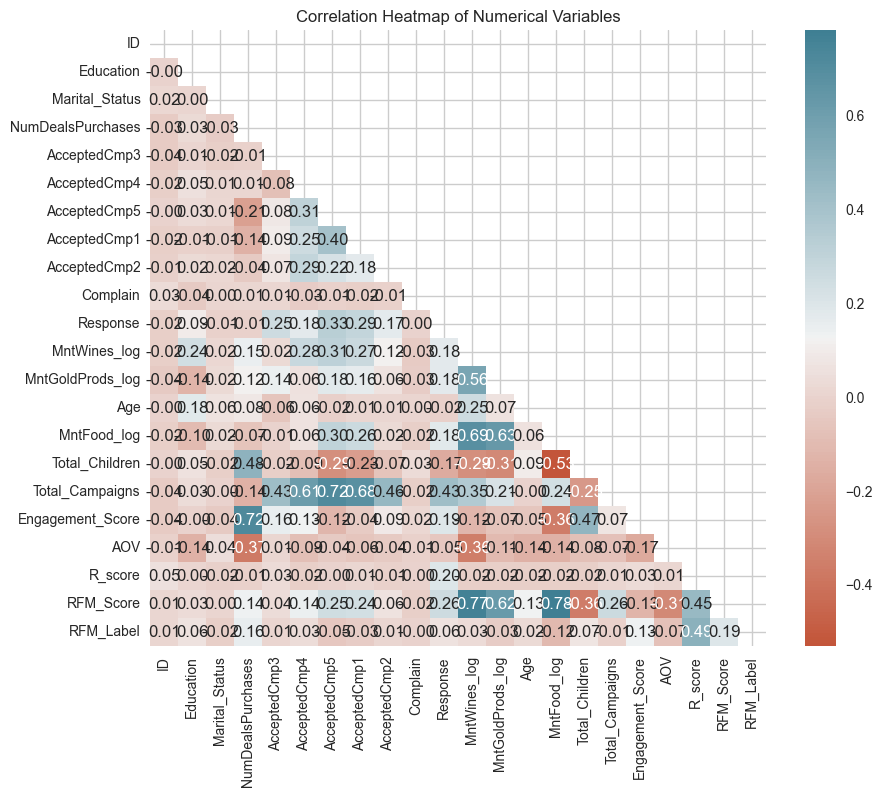

In [11]:
# Select only the numerical columns
numerical_X1 = X.select_dtypes(include=['float64', 'int64', 'int32'])

# Compute the correlation matrix
corr_matrix_final = numerical_X1.corr()

# Create a mask for the upper triangle (ensuring the diagonal is included in the mask)
mask = np.triu(np.ones_like(corr_matrix_final, dtype=bool))

# Create a diverging color palette
my_palette = sns.diverging_palette(20, 220, n=200)

# Create the heatmap with annotations enabled
plt.figure(figsize=(10, 8))  # Adjust the size to fit all annotations properly
sns.heatmap(corr_matrix_final, mask=mask, annot=True, fmt=".2f",
            cmap=my_palette, cbar=True, square=True)

plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

## Feature Selection

In [12]:
# Create the Target
y = X['Response']

In [13]:
X.head()

,ID,Education,Marital_Status,NumDealsPurchases,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,...,MntGoldProds_log,Age,MntFood_log,Total_Children,Total_Campaigns,Engagement_Score,AOV,R_score,RFM_Score,RFM_Label
0,0,0.50,0.25,-0.793909,0.0,0.0,0.0,0.0,0.0,0.0,...,0.688513,0.196429,1.379447,0.000000,0.0,0.105263,0.058889,0.25,0.583333,0.250
1,1,0.50,0.50,-0.793909,0.0,0.0,0.0,0.0,1.0,0.0,...,0.386373,0.625000,-0.534509,0.000000,1.0,0.421053,0.025179,1.00,0.750000,1.000
2,9,0.75,0.50,1.157322,0.0,0.0,0.0,0.0,0.0,0.0,...,0.364581,0.375000,-1.171508,0.666667,0.0,0.631579,0.033752,0.00,0.166667,0.000
3,13,1.00,1.00,-0.143499,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.790620,0.875000,-1.466439,0.333333,0.0,0.421053,0.050907,0.50,0.166667,0.875
4,17,1.00,0.25,1.157322,0.0,0.0,0.0,0.0,0.0,0.0,...,0.963461,0.446429,0.645911,0.333333,0.0,0.473684,0.021084,0.00,0.583333,0.500


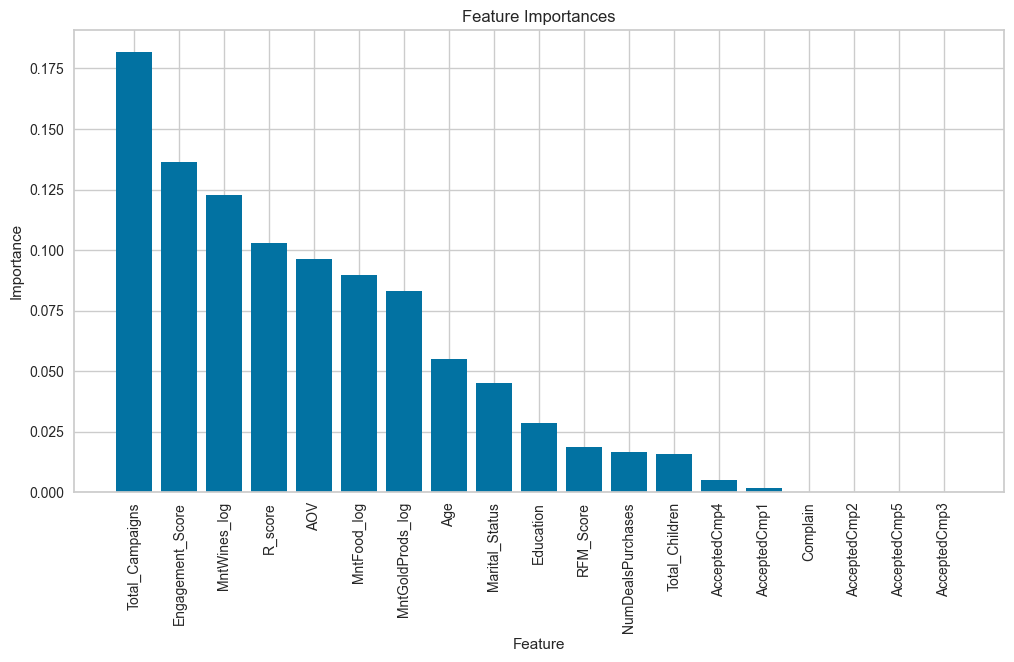

In [14]:
# Replace commas with dots for numerical columns and convert to floats
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].str.replace(',', '.')
        try:
            X[col] = X[col].astype(float)
        except ValueError:
            pass

# Drop rows with missing values
X = X.dropna()

# Split the data into features and target variable
if 'Response' in X.columns:
    features = X.drop(columns=['ID', 'RFM_Label', 'Response'])
    y = X['Response']
else:
    features = X.drop(columns=['ID', 'RFM_Label'])
    y = X['Response']

# Encode the target variable if necessary
le = LabelEncoder()
y = le.fit_transform(y)

# Fit the Decision Tree model
dt = DecisionTreeClassifier()
dt.fit(features, y)

# Get feature importances
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = features.columns

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(features.shape[1]), importances[indices], align='center')
plt.xticks(range(features.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()


In [15]:
# Since these variables showed lower relevance, we decided to remove them

X = X.drop(['ID', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','Complain'], axis=1)

### Modeling - Support vector machine

In [16]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=13)

In [17]:
# Remove the Target from the training
X_train = X_train.drop(['Response'],axis=1)
X_test = X_test.drop(['Response'],axis=1)

In [18]:
X.head()

,Education,Marital_Status,NumDealsPurchases,Response,MntWines_log,MntGoldProds_log,Age,MntFood_log,Total_Children,Total_Campaigns,Engagement_Score,AOV,R_score,RFM_Score,RFM_Label
0,0.50,0.25,-0.793909,0.0,0.443760,0.688513,0.196429,1.379447,0.000000,0.0,0.105263,0.058889,0.25,0.583333,0.250
1,0.50,0.50,-0.793909,1.0,0.814311,0.386373,0.625000,-0.534509,0.000000,1.0,0.421053,0.025179,1.00,0.750000,1.000
2,0.75,0.50,1.157322,0.0,-0.351912,0.364581,0.375000,-1.171508,0.666667,0.0,0.631579,0.033752,0.00,0.166667,0.000
3,1.00,1.00,-0.143499,0.0,-0.948421,-0.790620,0.875000,-1.466439,0.333333,0.0,0.421053,0.050907,0.50,0.166667,0.875
4,1.00,0.25,1.157322,0.0,0.991520,0.963461,0.446429,0.645911,0.333333,0.0,0.473684,0.021084,0.00,0.583333,0.500


Counter({0: 1422, 1: 250})


<Axes: xlabel='y', ylabel='count'>

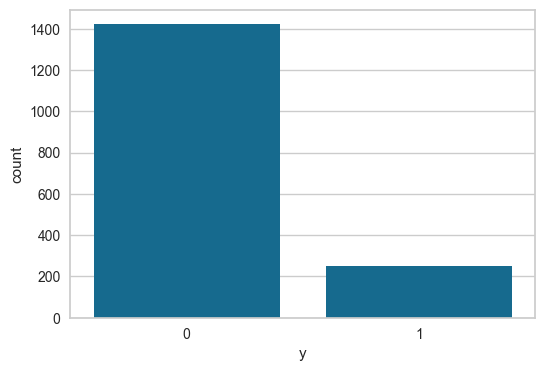

In [19]:
# Display target balance in the training dataset
print(collections.Counter(y_train))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="y", data=pd.DataFrame(data={'y':y_train}), ax=ax)

Counter({0: 1422, 1: 1422})


<Axes: xlabel='Response', ylabel='count'>

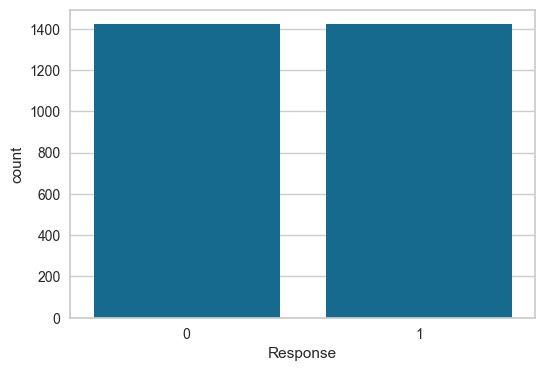

In [20]:

# Applyting SMOTE to generare new instances (oversampling)
sm = SMOTE(random_state=123, sampling_strategy=1.0)
X_train2, y_train2 = sm.fit_resample(X_train , y_train)

# Display target balance in the training dataset
print(collections.Counter(y_train2))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="Response", data=pd.DataFrame(data={'Response':y_train2}), ax=ax)

In [21]:
from sklearn.svm import SVC
# Create object and train the model
classModel = SVC(gamma='scale', random_state=123, probability=True)
classModel.fit(X_train2, y_train2)

SVC(probability=True, random_state=123)

### Evaluation - SVM

In [22]:
# predict y for X_train and X_test
y_pred_train = classModel.predict(X_train2) 
y_pred_test = classModel.predict(X_test) 

In [23]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
  train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain),
                metricsObj.f1_score(yTrain, yPredTrain),
                metricsObj.roc_auc_score(yTrain, yPredTrain)
                ]
  test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest),
               metricsObj.recall_score(yTest, yPredTest),
               metricsObj.f1_score(yTest, yPredTest),
               metricsObj.roc_auc_score(yTest, yPredTest)
               ]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [24]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

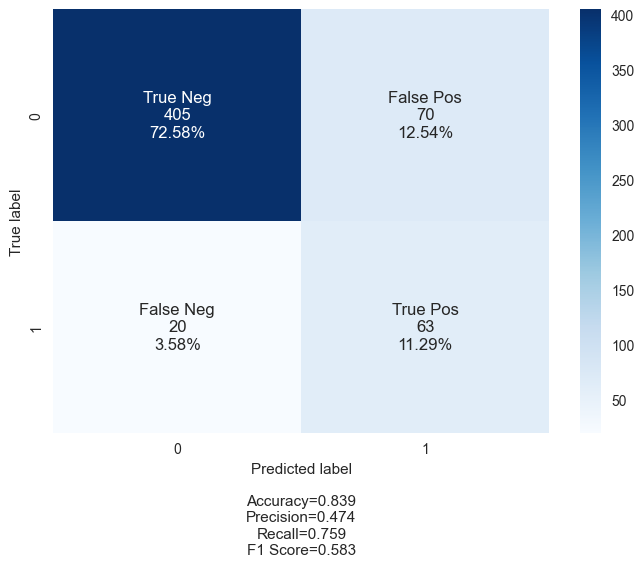

In [25]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

- **High True Negative Rate**: The model is quite effective at correctly identifying customers who will not respond to the campaign, as evidenced by the high number of true negatives (405).
- **Moderate True Positive Rate**: The model correctly identifies a portion of the customers who will respond (63), but there's room for improvement.
- **False Positives and Negatives**: There are a notable number of false positives (70) and some false negatives (20), indicating that the model is making some errors in both directions.s.

In [26]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train2, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.887482,0.838710
1,PRECISION,0.869799,0.473684
2,RECALL,0.911392,0.759036
3,F1 SCORE,0.890110,0.583333
4,AUC,0.887482,0.805834


- The model performs well on training data but less effectively on test data, particularly in precision and F1 score.
- It consistently identifies a large proportion of actual positive cases, which is useful for ensuring potential responders are not missed.
- There is a significant drop in precision on test data suggests that the model may incorrectly classify many non-responders as responders, which could lead to inefficiencies in marketing efforts.s.

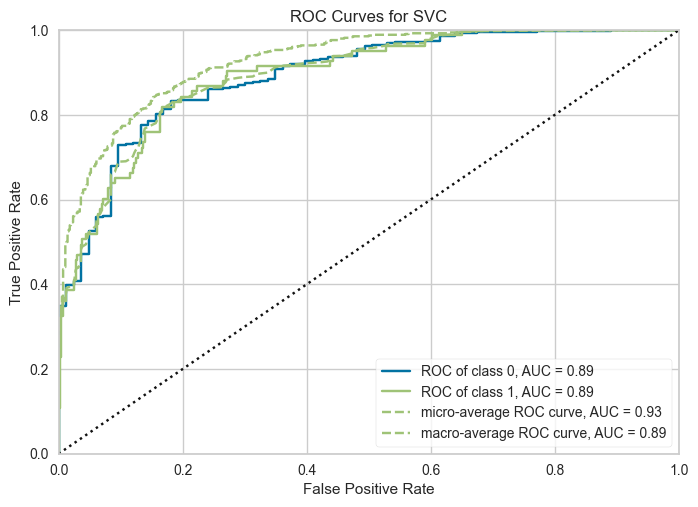

<Axes: title={'center': 'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [27]:
# Let´s plot the ROC curve
visualizer = ROCAUC(classModel, classes=['0','1'])
visualizer.fit(X_train2, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

- The AUC values for both classes (0.89) indicate that the SVC model has a good ability to distinguish between the two classes (responders and non-responders). An AUC of 0.89 suggests that there is an 89% chance that the model will correctly distinguish between a randomly chosen responder and a non-responder.
- The micro-average ROC curve combines all instances and computes the average performance of the model. An AUC of 0.93 suggests that overall, the model performs very well in distinguishing between the two classes across all thresholds.
- Finally, the macro-average ROC curve computes the average performance of the model treating all classes equally. An AUC of 0.89 shows that the model has a consistently good performance across both classes.s.

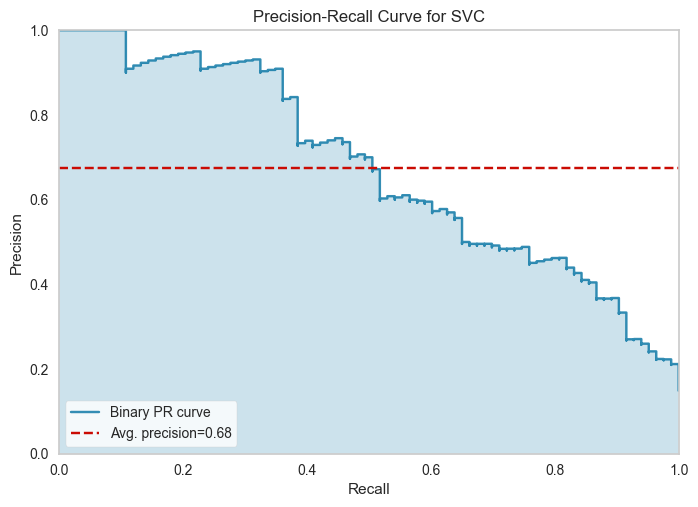

<Axes: title={'center': 'Precision-Recall Curve for SVC'}, xlabel='Recall', ylabel='Precision'>

In [28]:
# Precison-Recall curve
visualizer = PrecisionRecallCurve(classModel, classes=['0','1'])
visualizer.fit(X_train2, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

- The average precision of 0.68 suggests that the model has moderate performance in identifying positive class instances. This metric combines the precision and recall values at all thresholds to give a single number representing the overall performance.

- At the left end of the curve, the model achieves high precision but at low recall, indicating that when the model is very confident about a positive prediction, it is often correct, but it misses many actual positives.

- On the other hand, as recall increases, precision decreases. This trade-off shows that as the model tries to capture more true positives (increasing recall), it also includes more false positives, thus reducing precision.n.